# Dealing with Sparsity by removing columns and rows with too many Nan values.
# Since Positive class is minority class - Apply stringent filter thresholds

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [45]:
num = pd.read_table("ALL_num_positives.csv", sep='\t')
cat = pd.read_table("ALL_cat_positives.csv", sep='\t')
dat = pd.read_table("ALL_dat_positives.csv", sep='\t')

# Functions for assessing Na / non-na ratio per column

In [40]:
# For each column, count the number of non Na values
num_column_NonNa_Count = num.notnull().sum(axis=0) 
cat_column_NonNa_Count = cat.notnull().sum(axis=0) 
dat_column_NonNa_Count = dat.notnull().sum(axis=0) 


In [41]:
# This function finds the value of each percentile 
def PercentileInvestigator(start, end, increment, dataIn):
    percentile_coll = []
    count_coll = []
    for i in range(start, end, increment):
        percentile_coll.append(i)
        count_coll.append(np.percentile(dataIn, i))
    print dataIn.describe()
    return [percentile_coll, count_coll]

In [42]:
def PlotIt(titleIn) :
    fig = plt.figure()
    fig.set_size_inches(10, 10)
    fig.subplots_adjust(bottom=0.2)
    ax1 = fig.add_subplot(211)
    fig.subplots_adjust(bottom=0.2)
    line1 = ax1.plot(percentile_col, count_col,'bo-')
    ax1.set_xlabel('Percentile', fontsize=25)
    ax1.set_ylabel('Non-Na Count', fontsize=25)
    plt.title(titleIn, fontsize=40)

# Clear columns containing a high level of Na for Numeric dataset

count     970.000000
mean      749.225773
std      1192.947085
min         1.000000
25%        37.000000
50%       162.000000
75%       728.000000
max      3952.000000
dtype: float64


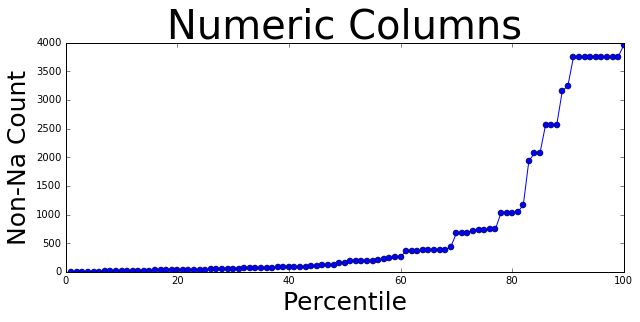

In [43]:
percentile_col, count_col= PercentileInvestigator(start=1, end=101, increment=1, dataIn = num_column_NonNa_Count)
PlotIt("Numeric Columns")

In [44]:
# Use 83rd Percentile (1934 non Na values) to filter columns. 
print np.percentile(num_column_NonNa_Count, 83) 
print num.shape # 970 columns before.
num = num.dropna(thresh=1934, axis="columns") # axis = {0 or ‘index’, 1 or ‘columns’}
print num.shape # 166 columns remaining.

1934.0
(3952, 970)
(3952, 166)


# Clear columns containing a high level of Na for Categorical dataset

count    2142.000000
mean      112.936975
std       460.497570
min         0.000000
25%         0.000000
50%         0.000000
75%         2.000000
max      3907.000000
dtype: float64


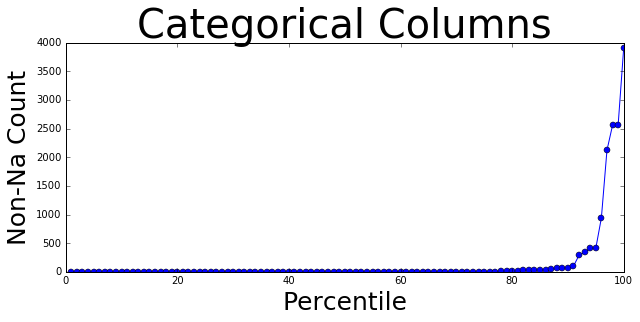

In [13]:
percentile_col, count_col = PercentileInvestigator(start=1, end=101, increment=1, dataIn = cat_column_NonNa_Count)
PlotIt("Categorical Columns")

In [18]:
print np.percentile(cat_column_NonNa_Count, 97) 
cat = cat.dropna(thresh=2122, axis="columns") # axis = {0 or ‘index’, 1 or ‘columns’}

2122.18


# Clear columns containing a high level of Na for Date dataset

count    1158.000000
mean      695.042314
std      1146.950118
min         0.000000
25%        32.000000
50%       151.000000
75%       677.750000
max      3891.000000
dtype: float64


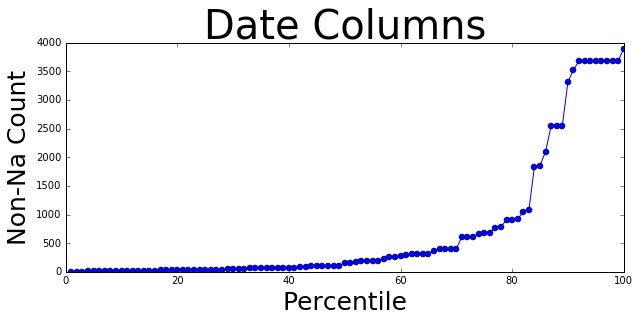

In [19]:
percentile_col, count_col = PercentileInvestigator(start=1, end=101, increment=1, dataIn = dat_column_NonNa_Count)
PlotIt("Date Columns")

In [20]:
print np.percentile(dat_column_NonNa_Count, 90) 
dat = dat.dropna(thresh=3312, axis="columns") # axis = {0 or ‘index’, 1 or ‘columns’}

3313.0


# Check shape of dataframes after Non-Na threshold filtering on columns

In [21]:
### date  and categorical columns were specifically chosen to not have a lot of Na columns
print cat.shape
print dat.shape

### threshold for column deletion based on Na-Non-Na ratio is more relaxed for categoricals as these will be imputed. 
print num.shape

(3907, 62)
(3891, 122)
(3952, 970)


# Changing non numeric categorical columns to numeric representation

In [ ]:
cat = cat.drop('Response', 1)
# Here we show that all other columns other than Id has only binary categories...
# This means there is no point in trying to fill in Nas because only one class exist. 
duplicateCount = cat.T.apply(lambda x: x.nunique(), axis=1) # Here we show that 
print duplicateCount[duplicateCount > 2]

In [23]:
cat = cat.replace('T1',1)
datcat = pd.merge(cat, dat, on='Id')

# Concatenate all 3 datasets together & Remove rows to with high Na count

count    2117.000000
mean      335.658951
std        62.280775
min         3.000000
25%       315.000000
50%       343.000000
75%       374.000000
max       442.000000
dtype: float64


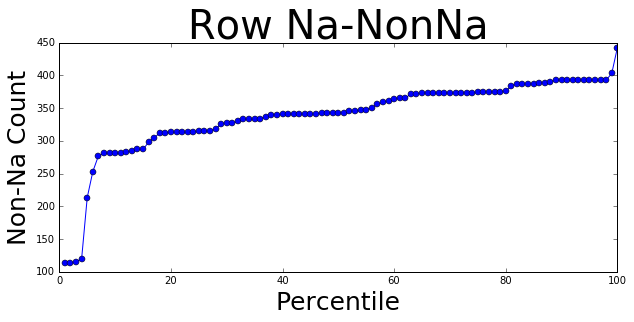

In [24]:
dat_num_cat = pd.merge(datcat, num, on='Id')
row_NonNa_Count = dat_num_cat.notnull().sum(axis=1) 

def PercentileInvestigator(start, end, increment, dataIn):
    percentile_coll = []
    count_coll = []
    for i in range(start, end, increment):
        percentile_coll.append(i)
        count_coll.append(np.percentile(dataIn, i))
    print dataIn.describe()
    return [percentile_coll, count_coll]

percentile_col, count_col = PercentileInvestigator(start=1, end=101, increment=1, dataIn = row_NonNa_Count)
PlotIt("Row Na-NonNa")

In [34]:
np.percentile(row_NonNa_Count, 15)

255.0

In [44]:
dat_num_cat2 = dat_num_cat.dropna(thresh=255, axis="index") # axis = {0 or ‘index’, 1 or ‘columns’}

In [45]:
dat_num_cat2.shape

(1815, 347)

# Here are the rows to keep with atleast ~250 data points per row

In [67]:
Ids_to_keep = dat_num_cat2[["Id"]].values.tolist()
Ids_to_keep = reduce(lambda x,y: x+y, Ids_to_keep )
datcat= datcat[datcat["Id"].isin(Ids_to_keep)]
num = num[num["Id"].isin(Ids_to_keep)]

# Write out filtered files for numerical + (data + categorical) data

In [75]:
datcat.to_csv("Stage2_output_datcat.csv", sep='\t', index= False )

In [76]:
num.to_csv("Stage2_output_num.csv", sep='\t', index= False )

# Write out low quality data for later tests

In [58]:
num = pd.read_table("ALL_num_positives.csv", sep='\t')
cat = pd.read_table("ALL_cat_positives.csv", sep='\t')
dat = pd.read_table("ALL_dat_positives.csv", sep='\t')

In [8]:
#cat = cat.drop('Response', 1)
# Here we show that all other columns other than Id has only binary categories...
# This means there is no point in trying to fill in Nas because only one class exist. 
#duplicateCount = cat.T.apply(lambda x: x.nunique(), axis=1) # Here we show that 
#output = duplicateCount[duplicateCount > 2]

In [29]:
#colSelect = list(output.index[1:len(output.index)])

In [33]:
#colSelect.append("Id")

In [ ]:
#cat[colSelect]    # definately add these columns in 

In [51]:
datcat = pd.merge(cat, dat, on='Id')

In [52]:
dat_num_cat = pd.merge(datcat, num, on='Id')

In [60]:
dat_num_cat.to_csv("All_positives_all_quality.csv", sep='\t', index= False )